#Model

In [136]:
import numpy as np
import pandas as pd
import time
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
np.random.seed()

pRand = 5
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-deep')

In [137]:
path = "https://raw.github.com/lateNighter/UPP/main/final.csv"
data = pd.read_csv(path)

In [138]:
data

,Year,Rooms,TotalArea,LivingArea,Floor,Price
0,2023,2,40.0,27.0,1.000000,8015408
1,2023,2,37.5,24.8,0.294118,7657921
2,2023,2,40.0,27.0,0.823529,7951971
3,2024,2,35.0,25.0,0.176471,5602638
4,2024,3,62.0,35.0,0.823529,8940577
...,...,...,...,...,...,...
825,2024,2,37.1,19.1,0.823529,6424050
826,2024,2,36.6,23.3,0.411765,6791130
827,2024,2,50.0,23.0,0.764706,8817178
828,2024,2,36.1,20.3,0.529412,6472188


In [139]:
cv = KFold(n_splits=5,shuffle=True,random_state=pRand)

In [140]:
data['Price']=data['Price']/1000000

In [141]:
print(data.shape)
data.dropna(inplace=True)
x=data.drop(columns=['Price'])
y=data['Price']
x=(x-np.mean(x)) / np.std(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)
print(data.shape)

(830, 6)
(830, 6)


In [142]:
print('\nDecision Tree Regression\n')

depths = range(1,31)
criterions = ['mse','mae']

bestMAE = np.inf #set infinite as starting value
bestDepth = 0
bestCriterion = ''
maeR2Scores = []
mseR2Scores = []
maeMAEs = []
mseMAEs = []

for criterion in criterions:
    
    for depth in depths:
        
        DTregressor = DecisionTreeRegressor(random_state = pRand, max_depth=depth, criterion=criterion)
        _ = DTregressor.fit(x_train, y_train)
        y_pred = DTregressor.predict(x_test)
        
        if(criterion == 'mae'):
            maeR2Scores.append(DTregressor.score(x_train,y_train))
            maeMAEs.append(metrics.mean_absolute_error(y_test,y_pred))
            
        if(criterion == 'mse'):
            mseR2Scores.append(DTregressor.score(x_train,y_train))
            mseMAEs.append(metrics.mean_absolute_error(y_test,y_pred))
            
        if(metrics.mean_absolute_error(y_test,y_pred)<bestMAE):
            bestMAE = metrics.mean_absolute_error(y_test,y_pred)
            bestDepth = depth
            bestCriterion = criterion



Decision Tree Regression



In [143]:
print('\nRandom Forest Regression\n')

n_estimators = [10,50,100]


bestMAE = np.inf #set infinite as starting value
bestN_estimators = 0 #number of trees
R2Scores = []
MAEs = []

for n_estimator in n_estimators:
            
    RFregressor = RandomForestRegressor(random_state = pRand, max_depth=bestDepth, criterion=bestCriterion, n_estimators=n_estimator)
    _ = RFregressor.fit(x_train, y_train)
    y_pred = RFregressor.predict(x_test)
        
    R2Scores.append(RFregressor.score(x_train,y_train))
    MAEs.append(metrics.mean_absolute_error(y_test,y_pred))
            
    if(metrics.mean_absolute_error(y_test,y_pred)<bestMAE):
        bestMAE = metrics.mean_absolute_error(y_test,y_pred)
        bestN_estimators = n_estimator
           
        


Random Forest Regression




Best parameters for classifier:

- Criterion: mse
- Max depth: 12
- Best number of estimators: 100
- Mean Absolute Error of classifier with best parameters: 1

10 estimators - MAE: 1
50 estimators - MAE: 1
100 estimators - MAE: 1




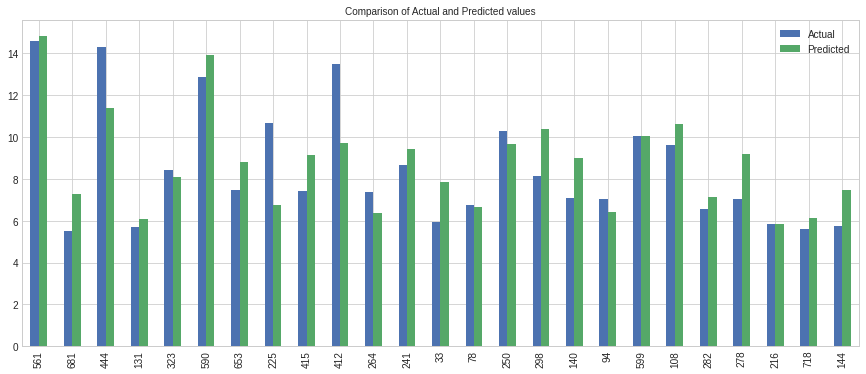

model score train 0.95311495606962
model score test 0.74538089689354


In [144]:
print('\nBest parameters for classifier:\n')
print('- Criterion: %s' %bestCriterion)
print('- Max depth: %s' %bestDepth)
print('- Best number of estimators: %s' %bestN_estimators)
print('- Mean Absolute Error of classifier with best parameters: %d\n' %bestMAE)

for i in range(3):
    print('%d estimators - MAE: ' %n_estimators[i] + '%d' %MAEs[i])

print('\n')

RFregressor = RandomForestRegressor(random_state = pRand, max_depth=bestDepth, criterion=bestCriterion, n_estimators=bestN_estimators)
_ = RFregressor.fit(x_train, y_train)
y_pred = RFregressor.predict(x_test)

res = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
df1 = res.head(25)
df1.plot(kind='bar',figsize=(15,6))
plt.title('Comparison of Actual and Predicted values', fontsize=10)
plt.show()

print('model score train', RFregressor.score(x_train,y_train))
print('model score test', RFregressor.score(x_test,y_test))

In [145]:
import pickle
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import requests

class Model:
  def __init__(self, model):
    self.model = model

  def predict(self, sample):
    '''
    Parameters:
    sample (DataFrame): Year: int; Rooms: int; TotalArea: float; LivingArea: float; 
    Floor(actual floor/total floors): float.
  
    Returns:
    float: Predicted price
    '''
    sample=sample.to_numpy().reshape(1,-1)
    sample=(sample-np.mean(sample)) / np.std(sample)
    res = (self.model.predict(sample)*1000000)[0]
    return res

model=Model(RFregressor)
pickle.dump(model, open('model.pkl', 'wb'))

# Backend

In [1]:
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import requests

class Model:
  def __init__(self, model):
    self.model = model

  def predict(self, sample):
    '''
    Parameters:
    sample (DataFrame): Year: int; Rooms: int; TotalArea: float; LivingArea: float; 
    Floor(actual floor/total floors): float.
  
    Returns:
    float: Predicted price
    '''
    sample=sample.to_numpy().reshape(1,-1)
    sample=(sample-np.mean(sample)) / np.std(sample)
    res = (self.model.predict(sample)*1000000)[0]
    return res

if __name__ == "__main__":
    path = "https://raw.github.com/lateNighter/UPP/main/model.pkl"
    response = requests.get(path, allow_redirects=True)
    if(response.status_code==requests.codes.ok):
        open('model.pkl', 'wb').write(response.content)

    pickled_model = pickle.load(open('model.pkl', 'rb'))

    df=pd.DataFrame([[2019,2,40.0,27.0,1]])
    print(pickled_model.predict(df))

6898521.94
